Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=['rgiid', 'x', 'y'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [4]:
df_main['SMB_calc'] = df_main['beta']*(df_main['surface_elevation']-df_main['ELA'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['Unnamed: 0', 'ELA', 'beta', 'Name', 'Area', 'cmb'])
df.dropna(how='any', inplace=True)

In [7]:
df.groupby('Surge').count()

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
Surge,,,,,,,,,,,
0,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675
2,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249
3,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897


In [8]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    15146
Name: label, dtype: int64

In [9]:
df[df['label']==1].shape[0]

15146

In [10]:
df.shape

(83821, 12)

### Resampled

In [11]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [12]:
df_downsampled.shape

(30292, 12)

In [13]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [14]:
train_labels.sum()/train_labels.shape[0]

0.5

In [15]:
test_labels.sum()/test_labels.shape[0]

0.5

In [16]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'SMB_calc',
 'WH',
 'WHsin',
 'dummy']

In [17]:
train.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00515,441975.150359,8.727522e+06,19.5,0,264.174900,38.879795,303.0547,576.297132,2.549741,-1.518291,14.822535,13567.916665,0.223783
RGI60-07.00873,548147.700372,8.772440e+06,7.4,0,1034.511800,81.036380,1115.5482,4308.036475,0.253687,0.200014,53.161759,313745.899081,0.231155
RGI60-07.00859,530846.114530,8.837916e+06,9.1,1,579.684600,214.568920,794.2535,7218.261007,0.504620,0.259796,33.640758,494224.160475,0.740471
RGI60-07.00315,578764.810581,8.620960e+06,9.4,1,-28.271210,97.271210,69.0000,2263.341551,2.532262,-1.377222,23.268360,5454.507405,0.690097
RGI60-07.00233,514508.764759,8.598699e+06,10.7,0,-33.664413,150.664410,117.0000,864.509164,3.193687,-3.300643,5.737979,-124602.440895,0.072363


In [18]:
train_labels.shape

(21204,)

In [19]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.83762,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.524760
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.05932,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.260645
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.18905,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.114072
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.94358,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.969736
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.85196,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.956013


# Gradient boosting

In [21]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [23]:
df_main.columns

Index(['Unnamed: 0', 'Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed',
       'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff', 'SMB_calc', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [24]:
df_main.dropna().shape

(73514, 18)

In [25]:
df_main.dropna(inplace=True)

In [26]:
test_full_labels = df_main['Surge']
# test_full = df_main.dropna(inplace=True)
test_full = df_main.drop(columns=['Unnamed: 0', 'Surge', 'Area', 'Name', 'ELA', 'beta', 'cmb'])
test_full

Slope  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00006 537467.580455 8.536842e+06   12.6         1  591.49146   
               537404.091767 8.536902e+06   12.6         1  591.49146   
               537340.603079 8.536963e+06   12.6         1  565.43870   
               537277.114391 8.537023e+06   12.6         1  547.37540   
               537213.625703 8.537084e+06   12.6         1  514.92160   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06   11.7         0  237.64468   
               534310.362510 8.675249e+06   11.7         0  233.07228   
               534309.250485 8.675291e+06   11.7         0  233.07228   
               534308.138459 8.675333e+06   11.7         0  233.18828   
               534307.026431 8.675375e+06   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00006 537467.580455 8.536842e+06  24.508570          616.00000   
               537404.091767 8.536902e+06  24.508570          616.00000   
               537340.603079 8.536963e+06  23.561293          589.00000   
               537277.114391 8.537023e+06  24.624578          572.00000   
               537213.625703 8.537084e+06  27.078419          542.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00006 537467.580455 8.536842e+06       1098.398114  1.653396   
               537404.091767 8.536902e+06       1141.233362  1.586801   
               537340.603079 8.536963e+06       1144.919151  1.520206   
               537277.114391 8.537023e+06       1105.995748  1.453610   
               537213.625703 8.537084e+06       1069.477866  1.434204   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc         WH         WHsin  \
rgiid          x             y                                                 
RGI60-07.00006 537467.580455 8.536842e+06  0.752798  44.816899    905.138048   
               537404.091767 8.536902e+06  0.753056  46.564665    940.436555   
               537340.603079 8.536963e+06  0.573153  48.593222    907.007776   
               537277.114391 8.537023e+06  0.459876  44.914303    915.712884   
               537213.625703 8.537084e+06  0.259794  39.495580    973.715707   
...                                             ...        ...           ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323   5.529005 -10693.410549   
               534310.362510 8.675249e+06 -1.604864   5.495975  -9139.908345   
               534309.250485 8.675291e+06 -1.606379   5.104727  -8489.256385   
               534308.138459 8.675333e+06 -1.604294   4.799500  -8133.568561   
               534307.026431 8.675375e+06 -1.604788   4.572378  -7748.670623   

                                              dummy  
rgiid          x             y                       
RGI60-07.00006 537

In [27]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test[test.columns], label=test_labels)

In [28]:
test_labels.shape

(9088,)

In [29]:
test_labels.shape

(9088,)

In [30]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.83762,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.524760
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.05932,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.260645
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.18905,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.114072
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.94358,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.969736
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.85196,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.956013


In [32]:
index = test.index
index

MultiIndex([('RGI60-07.00465',  478371.3031312914, 8716493.079874346),
            ('RGI60-07.01090',  489770.3210364708, 8649559.782740187),
            ('RGI60-07.00406',  557921.3415349098, 8663047.163578922),
            ('RGI60-07.00862',  541092.9734147982, 8860542.614031836),
            ('RGI60-07.00169',  530699.5351531929, 8626462.749319887),
            ('RGI60-07.00444',  552741.4042027425, 8517411.801410008),
            ('RGI60-07.00250',  548546.2763983625,   8566352.8981585),
            ('RGI60-07.00251',  553807.8795326179, 8570283.304498289),
            ('RGI60-07.00324',  544261.4895316308, 8569961.734064246),
            ('RGI60-07.00388',  545250.6456611605, 8671672.238709187),
            ...
            ('RGI60-07.00203',   553516.590486451,   8650467.1416643),
            ('RGI60-07.00064',  618984.1885800683, 8820047.261795316),
            ('RGI60-07.01458',  555727.1436176045, 8733388.058027552),
            ('RGI60-07.00476', 462320.27653640026, 8730102.39

In [33]:
test

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.837620,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.524760
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.059320,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.260645
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.189050,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.114072
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.943580,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.969736
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.851960,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.956013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01164,490373.714054,8.827258e+06,11.0,0,779.663400,29.336622,809.00000,610.638536,1.196574,-0.154676,20.814889,-1.791390e+04,0.327379
RGI60-07.00244,517785.529431,8.572797e+06,8.7,1,159.438140,326.561860,486.00000,3647.614162,1.632135,-0.321394,11.169749,7.897102e+05,0.549593
RGI60-07.01324,438854.874150,8.849988e+06,28.3,0,390.872800,21.127195,412.00000,384.196907,2.246294,-0.467437,18.184946,-2.083091e+02,0.474747


In [34]:
test_full.index

MultiIndex([('RGI60-07.00006', 537467.5804552714, 8536841.775761165),
            ('RGI60-07.00006', 537404.0917668121,  8536902.25261285),
            ('RGI60-07.00006', 537340.6030786886, 8536962.729457755),
            ('RGI60-07.00006', 537277.1143909006, 8537023.206295874),
            ('RGI60-07.00006', 537213.6257034478, 8537083.683127213),
            ('RGI60-07.00006', 537150.1370163298, 8537144.159951767),
            ('RGI60-07.00006', 537088.1542639694, 8537142.654018957),
            ('RGI60-07.00006',  537024.665580745, 8537203.130833503),
            ('RGI60-07.00006', 536961.1768978542, 8537263.607641263),
            ('RGI60-07.00006', 536897.6882152973, 8537324.084442247),
            ...
            ('RGI60-07.01567', 534233.0628686899, 8674994.491536722),
            ('RGI60-07.01567',  534231.950853308, 8675036.477414005),
            ('RGI60-07.01567', 534230.8388363951, 8675078.463291207),
            ('RGI60-07.01567', 534229.7268179511, 8675120.449168332),
    

In [35]:
# predictions_xgboost = xgb.predict(dmatrix_test)
predictions_xgboost = xgb.predict(test_full)
probabilities_xgboost = xgb.predict_proba(test_full)
# probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(dmatrix_test)
prob_0 = []
prob_1 = []
for n in np.arange(0, probabilities_xgboost.shape[0], 1):
    prob_0.append(probabilities_xgboost[:][:][n][0])
    prob_1.append(probabilities_xgboost[:][:][n][1])
    
df_probability_surge_full = pd.DataFrame({'Probability_0':prob_0, 'Probability_1':prob_1, 'Predictions':predictions_xgboost}, index=test_full.index)
df_probability_surge_full.reset_index(['x', 'y'], inplace=True)

In [36]:
df_probability_surge_full

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,537467.580455,8.536842e+06,0.808412,0.191588,0
RGI60-07.00006,537404.091767,8.536902e+06,0.808412,0.191588,0
RGI60-07.00006,537340.603079,8.536963e+06,0.808412,0.191588,0
RGI60-07.00006,537277.114391,8.537023e+06,0.808412,0.191588,0
RGI60-07.00006,537213.625703,8.537084e+06,0.755671,0.244329,0
...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,0.743000,0.257000,0
RGI60-07.01567,534310.362510,8.675249e+06,0.743000,0.257000,0
RGI60-07.01567,534309.250485,8.675291e+06,0.754379,0.245621,0


In [37]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import rioxarray as rxr

# from matplotlib import matplotlib.patches.Polygon

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


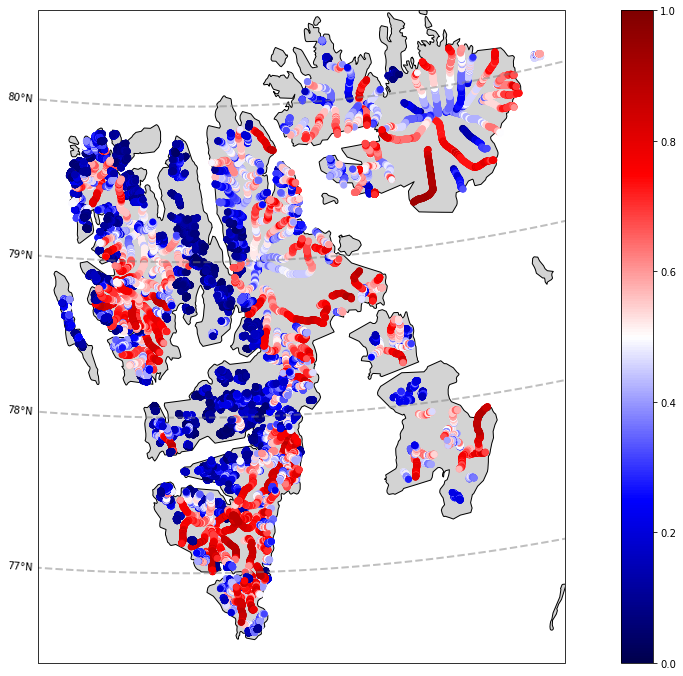

In [38]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

cbar = ax.scatter(df_probability_surge_full.x.values
        ,df_probability_surge_full.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=df_probability_surge_full.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

fig.colorbar(cbar)
# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
# ax.legend(fontsize=15)a

In [73]:
df_probability_surge_full.shape

(73514, 5)

In [71]:
df_probability_surge_full[df_probability_surge_full.Probability_1 > 0.5].count()

x                18139
y                18139
Probability_0    18139
Probability_1    18139
Predictions      18139
dtype: int64

In [74]:
73514/18139

4.0528143778598595

In [65]:
df_group_glacier = df_probability_surge_full.groupby('rgiid').mean()

In [66]:
df_group_glacier

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,535908.807782,8.540043e+06,0.703909,0.296091,0.000000
RGI60-07.00008,527557.142234,8.551328e+06,0.804375,0.195625,0.000000
RGI60-07.00010,519430.937310,8.551705e+06,0.923480,0.076520,0.000000
RGI60-07.00024,526981.868732,8.586109e+06,0.937906,0.062094,0.000000
RGI60-07.00025,671181.283498,8.829588e+06,0.100727,0.899273,1.000000
...,...,...,...,...,...
RGI60-07.01560,620597.048003,8.756407e+06,0.219049,0.780951,0.986111
RGI60-07.01561,595024.008354,8.786900e+06,0.512932,0.487068,0.500000
RGI60-07.01564,568867.596205,8.776534e+06,0.451190,0.548810,0.511628


In [67]:
prob_1 = df_group_glacier['Probability_1']

In [70]:
prob_1.shape

(738,)

In [69]:
prob_1[prob_1 > 0.5].count()

149

In [39]:
df_main.shape

(73514, 18)

In [40]:
df_probability_surge_full.shape

(73514, 5)

In [41]:
test_full_labels.shape

(73514,)

In [42]:
df_main

Unnamed: 0  Surge    Area  Slope  \
rgiid          x             y                                                
RGI60-07.00006 537467.580455 8.536842e+06         289      0  13.618   12.6   
               537404.091767 8.536902e+06         290      0  13.618   12.6   
               537340.603079 8.536963e+06         291      0  13.618   12.6   
               537277.114391 8.537023e+06         292      0  13.618   12.6   
               537213.625703 8.537084e+06         293      0  13.618   12.6   
...                                               ...    ...     ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3   5.350   11.7   
               534310.362510 8.675249e+06      130985      3   5.350   11.7   
               534309.250485 8.675291e+06      130986      3   5.350   11.7   
               534308.138459 8.675333e+06      130987      3   5.350   11.7   
               534307.026431 8.675375e+06      130988      3   5.350   11.7   

                                           TermType            Name  \
rgiid          x             y                                        
RGI60-07.00006 537467.580455 8.536842e+06         1  Chomjakovbreen   
               537404.091767 8.536902e+06         1  Chomjakovbreen   
               537340.603079 8.536963e+06         1  Chomjakovbreen   
               537277.114391 8.537023e+06         1  Chomjakovbreen   
               537213.625703 8.537084e+06         1  Chomjakovbreen   
...                                             ...             ...   
RGI60-07.01567 534269.488654 8.675206e+06         0    Moeysalbreen   
               534310.362510 8.675249e+06         0    Moeysalbreen   
               534309.250485 8.675291e+06         0    Moeysalbreen   
               534308.138459 8.675333e+06         0    Moeysalbreen   
               534307.026431 8.675375e+06         0    Moeysalbreen   

                                                 bed  thickness  \
rgiid          x             y                                    
RGI60-07.00006 537467.580455 8.536842e+06  591.49146  24.508570   
               537404.091767 8.536902e+06  591.49146  24.508570   
               537340.603079 8.536963e+06  565.43870  23.561293   
               537277.114391 8.537023e+06  547.37540  24.624578   
               537213.625703 8.537084e+06  514.92160  27.078419   
...                                              ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06  237.64468  50.380424   
               534310.362510 8.675249e+06  233.07228  46.717087   
               534309.250485 8.675291e+06  233.07228  46.717087   
               534308.138459 8.675333e+06  233.18828  47.159560   
               534307.026431 8.675375e+06  233.18828  47.159560   

                                           surface_elevation         ELA  \
rgiid          x             y                                             
RGI60-07.00006 537467.580455 8.536842e+06          616.00000  503.103638   
               537404.091767 8.536902e+06          616.00000  503.103638   
               537340.603079 8.536963e+06          589.00000  503.103638   
               537277.114391 8.537023e+06          572.00000  503.103638   
               537213.625703 8.537084e+06          542.00000  503.103638   
...                                                      ...         ...   
RGI60-07.01567 534269.488654 8.675206e+06          288.02512  627.625366   
               534310.362510 8.675249e+06          279.78937  627.625366   
               534309.250485 8.675291e+06          279.78937  627.625366   
               534308.138459 8.675333e+06          280.34784  627.625366   
               534307.026431 8.675375e+06          280.34784  627.625366   

                                               beta       cmb  \
rgiid          x             y                                  
RGI60-07.00006 537467.580455 8.536842e+06  0.006668  0.025495   
               537404.091767 8.5369

In [43]:
df_probability_surge_full

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,537467.580455,8.536842e+06,0.808412,0.191588,0
RGI60-07.00006,537404.091767,8.536902e+06,0.808412,0.191588,0
RGI60-07.00006,537340.603079,8.536963e+06,0.808412,0.191588,0
RGI60-07.00006,537277.114391,8.537023e+06,0.808412,0.191588,0
RGI60-07.00006,537213.625703,8.537084e+06,0.755671,0.244329,0
...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,0.743000,0.257000,0
RGI60-07.01567,534310.362510,8.675249e+06,0.743000,0.257000,0
RGI60-07.01567,534309.250485,8.675291e+06,0.754379,0.245621,0


In [44]:
df_compare = df_main.join(df_probability_surge_full.set_index(['x', 'y'], append=True), on=['rgiid', 'x', 'y'])

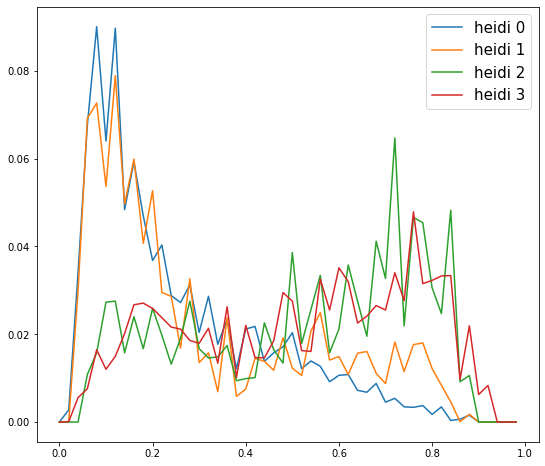

In [45]:
def gethist(data):
    h, e = np.histogram(data, bins=np.linspace(0, 1, 51))
#     print(h)
    h = h/h.sum()
#     print(h)
    return h, e

fig, ax = plt.subplots(figsize=(9, 8))

data = df_compare[df_compare.Surge==0].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='heidi 0')

data = df_compare[df_compare.Surge==1].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='heidi 1')

data = df_compare[df_compare.Surge==2].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='heidi 2')

data = df_compare[df_compare.Surge==3].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='heidi 3')

ax.legend(fontsize=15)

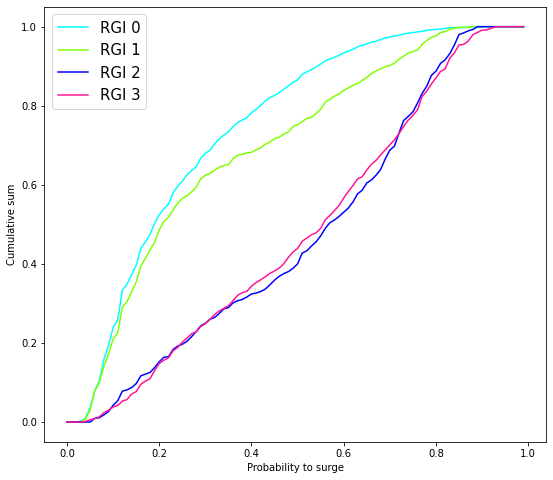

In [46]:
def gethist(data):
    h, e = np.histogram(data, bins=np.linspace(0, 1, 101))
#     print(h)
    h = h/h.sum()
#     print(h)
    return h.cumsum(), e

fig, ax = plt.subplots(figsize=(9, 8))

data = df_compare[df_compare.Surge==0].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 0', color='cyan')

data = df_compare[df_compare.Surge==1].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 1', color='chartreuse')

data = df_compare[df_compare.Surge==2].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 2', color='blue')

data = df_compare[df_compare.Surge==3].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 3', color='deeppink')
ax.set_xlabel('Probability to surge')
ax.set_ylabel('Cumulative sum')

ax.legend(fontsize=15)

In [47]:
data.shape

(10818, 21)

In [48]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

<AxesSubplot:>

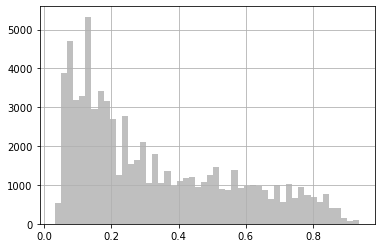

In [49]:
df_probability_surge_full.Probability_1.hist(bins=50, color='grey', alpha=0.5)

In [50]:
df_probability_surge_full_mean = df_probability_surge_full.groupby('rgiid').mean()
df_probability_surge_full_mean

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,535908.807782,8.540043e+06,0.703909,0.296091,0.000000
RGI60-07.00008,527557.142234,8.551328e+06,0.804375,0.195625,0.000000
RGI60-07.00010,519430.937310,8.551705e+06,0.923480,0.076520,0.000000
RGI60-07.00024,526981.868732,8.586109e+06,0.937906,0.062094,0.000000
RGI60-07.00025,671181.283498,8.829588e+06,0.100727,0.899273,1.000000
...,...,...,...,...,...
RGI60-07.01560,620597.048003,8.756407e+06,0.219049,0.780951,0.986111
RGI60-07.01561,595024.008354,8.786900e+06,0.512932,0.487068,0.500000
RGI60-07.01564,568867.596205,8.776534e+06,0.451190,0.548810,0.511628


<AxesSubplot:>

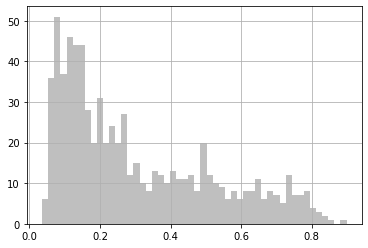

In [51]:
df_probability_surge_full_mean.Probability_1.hist(bins=50, color='grey', alpha=0.5)

In [52]:
fpr, tpr, t = metrics.roc_curve(y_true=df_test_mean['Surge'], y_score=df_probability_surge_mean['Probability_1'])

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=df_test_mean['Surge'], y_score=df_probability_surge_mean['Probability_1']),2))
    , x=0.6, y=0.0, fontsize=15
)

NameError: name 'df_test_mean' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax, color='b')

# Map of probability (mean over glaciers)

In [ ]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

In [ ]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8